# SETTING UP

In [75]:
%tensorflow_version 2.x
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow.keras import initializers
from tensorflow import keras
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from keras.callbacks import EarlyStopping

# Helper libraries
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
import numpy as np 
import pandas as pd 
import seaborn as sns
import os
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
from sklearn.metrics import (brier_score_loss, precision_score, recall_score,
                             f1_score, roc_auc_score, accuracy_score, roc_curve)
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.calibration import calibration_curve
from imblearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_predict, cross_validate
from sklearn.decomposition import PCA
import joblib
import os

# A. DATA

## Load and merge data

In [76]:
data = pd.read_csv('/content/drive/My Drive/Medicare Analysis/Data/newmm.csv')
mbs = pd.read_csv('/content/drive/My Drive/Medicare Analysis/Data/mbs_person_summary.csv')
pbs = pd.read_csv('/content/drive/My Drive/Medicare Analysis/Data/pbs_person_summary.csv')
drug = pd.read_csv('/content/drive/My Drive/Medicare Analysis/Data/pbs_item_manufacturer.csv')
datambs = pd.merge(data, mbs.drop(['last_mbs', 'sex','yob','Unnamed: 0','ptnt_state', 'lastcontact'], axis = 1), left_on='pin', right_on='pin', how='left')
datambspbs = pd.merge(datambs, pbs.drop(['last_pbs', 'sex','yob','Unnamed: 0','nstate', 'lastcontact'], axis = 1), left_on='pin', right_on='pin', how='left')\
            .drop(['No', 'last_pbs', 'last_mbs', 'Concatenate', 'MMGrouping', 'Agegrouping', 'Lastservice', 'disDays'], axis =1)
datambspbs.head()

,pin,yob,sex,age,GroupingA10,GroupingC0,GroupingC10,dead,nrecords_x,firstcontact_x,nstate,totalfeecharged,totalschedfee,totalbenpaid,totalnumserv,lengthcontact_x,ptnt_state,nrecords_y,firstcontact_y,n_pbs_code,total_bnft_amt,total_ptnt_cntrbtn_amt,total_prscrptn_cnt,lengthcontact_y
0,7275102840,1924,M,80,A10,C0,No,YES,118.0,1984-05-16,1.0,256930.0,287000.0,"$252,645.00",99.0,9951.0,VIC,80,2004-06-01,11,1955.97,384.60,80,2630
1,316560614,1925,F,79,No,C0,No,NO,778.0,1984-03-29,1.0,4356900.0,3690900.0,"$3,199,140.00",656.0,11233.0,VIC,325,2003-01-15,46,7112.05,1633.76,325,4367
2,1706657926,1919,F,85,No,C0,No,YES,304.0,1984-03-24,2.0,609220.0,714360.0,"$607,930.00",304.0,6898.0,QLD,3,2003-08-15,3,92.60,12.10,3,701
3,9352250463,1971,F,33,No,C0,No,NO,1548.0,1984-10-05,2.0,4990480.0,4982320.0,"$4,457,090.00",1255.0,11043.0,SA,1296,2003-01-02,74,31417.87,4149.50,1296,4380
4,6529626350,1944,F,60,No,C0,No,NO,250.0,1986-10-22,1.0,713230.0,743615.0,"$661,975.00",193.0,10251.0,NSW,414,2003-03-18,17,13493.79,1413.00,414,4304


## Pre-processing

In [77]:
df = pd.DataFrame(datambspbs)

# Drop all records with NA
df.dropna(inplace=True)

# Create firstcontactage features
df[['firstcontact_x','firstcontact_y']] = pd.to_datetime(df[['firstcontact_x','firstcontact_y']].stack(), format = '%Y-%m-%d').unstack()
df['firstcontact_x'] = pd.DatetimeIndex(df['firstcontact_x']).year
df['firstcontactage_x'] = df['firstcontact_x'] - df['yob']
df['firstcontact_y'] = pd.DatetimeIndex(df['firstcontact_y']).year
df['firstcontactage_y'] = df['firstcontact_y'] - df['yob']

# Write csv file
df.to_csv(r'/content/drive/My Drive/Medicare Analysis/Data/aggdata.csv', index = False, header=True)

# Drop yob and firstcontact features
df.drop(['firstcontact_x', 'firstcontact_y', 'yob', 'pin'], axis = 1, inplace=True)

# Redefine feature type
df[['nrecords_x']] = df[['nrecords_x']].astype('int64')

# Encoding categorical features
df = pd.get_dummies(df, columns = ['ptnt_state'])
df['totalbenpaid'] = df['totalbenpaid'].replace('[\$,]', '', regex=True).astype(float)
df['sex'] = df['sex'].replace({'F':1, 'M':0}).astype('uint8')
df['GroupingA10'] = df['GroupingA10'].replace({'A10':1, 'No':0}).astype('uint8')
df['GroupingC0'] = df['GroupingC0'].replace({'C0':1, 'No':0}).astype('uint8')
df['GroupingC10'] = df['GroupingC10'].replace({'C10':1, 'No':0}).astype('uint8')
df['dead'] = df['dead'].replace({'YES':1, 'NO':0}).astype('uint8')

# Shape of the final dataset
print("df.shape:", df.shape)
df.head()

df.shape: (346182, 27)


,sex,age,GroupingA10,GroupingC0,GroupingC10,dead,nrecords_x,nstate,totalfeecharged,totalschedfee,totalbenpaid,totalnumserv,lengthcontact_x,nrecords_y,n_pbs_code,total_bnft_amt,total_ptnt_cntrbtn_amt,total_prscrptn_cnt,lengthcontact_y,firstcontactage_x,firstcontactage_y,ptnt_state_NSW,ptnt_state_QLD,ptnt_state_SA,ptnt_state_UNK,ptnt_state_VIC,ptnt_state_WA
0,0,80,1,1,0,1,118,1.0,256930.0,287000.0,252645.0,99.0,9951.0,80,11,1955.97,384.60,80,2630,60,80,0,0,0,0,1,0
1,1,79,0,1,0,0,778,1.0,4356900.0,3690900.0,3199140.0,656.0,11233.0,325,46,7112.05,1633.76,325,4367,59,78,0,0,0,0,1,0
2,1,85,0,1,0,1,304,2.0,609220.0,714360.0,607930.0,304.0,6898.0,3,3,92.60,12.10,3,701,65,84,0,1,0,0,0,0
3,1,33,0,1,0,0,1548,2.0,4990480.0,4982320.0,4457090.0,1255.0,11043.0,1296,74,31417.87,4149.50,1296,4380,13,32,0,0,1,0,0,0
4,1,60,0,1,0,0,250,1.0,713230.0,743615.0,661975.0,193.0,10251.0,414,17,13493.79,1413.00,414,4304,42,59,1,0,0,0,0,0


## Class imbalance

Examples:
    Total: 346182
    Positive: 93164 (26.91% of total)



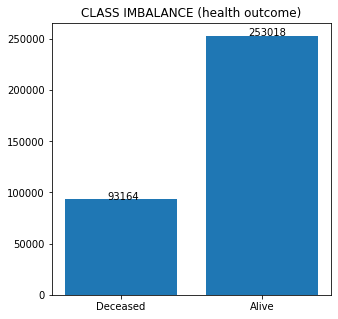

In [78]:
# Class imbalance problem
neg, pos = np.bincount(df['dead'])
total = neg + pos
print('Examples:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n'.format(total, pos, 100 * pos / total))
plt.figure(figsize=(5,5))
plt.bar(['Deceased', 'Alive'], height=[pos, neg])
# for i, v in zip(range(3), heights):
plt.text(x = 0-0.1, y = pos, s=str(round(pos,1)), fontsize=10)
plt.text(x = 1-0.1, y = neg, s=str(round(neg,1)), fontsize=10)
plt.title('CLASS IMBALANCE (health outcome)')
plt.savefig('/content/drive/My Drive/Medicare Analysis/Week 8&9 - IEEE Paper drafting/fig_1.pdf')
plt.show()

In [79]:
from warnings import filterwarnings
filterwarnings('ignore')

# B. NEURAL NETWORKS

## Model construction

In [98]:
mpl.rcParams['figure.figsize'] = (12, 10)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [99]:
METRICS = [
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc')
]

def make_model(metrics = METRICS, output_bias=None):
  if output_bias is not None:
    output_bias = tf.keras.initializers.Constant(output_bias)
  model = keras.Sequential([
      keras.layers.Dense(
          128, activation='relu', 
          kernel_initializer=tf.keras.initializers.he_uniform(seed=0),
          input_shape=(26,)),
      # keras.layers.Dense(
      #     128, activation='relu', 
      #     kernel_initializer=tf.keras.initializers.he_uniform(seed=0)),
      keras.layers.Dense(
          64, activation='relu', 
          kernel_initializer=tf.keras.initializers.he_uniform(seed=0)),
      # keras.layers.Dense(
      #     32, activation='relu', 
      #     kernel_initializer=tf.keras.initializers.he_uniform(seed=0)),
      keras.layers.Dense(
          32, activation='relu', 
          kernel_initializer=tf.keras.initializers.he_uniform(seed=0)),
      keras.layers.Dense(1, activation='sigmoid',
                         bias_initializer=output_bias),
  ])

  model.compile(
      optimizer=keras.optimizers.SGD(decay=1e-3),
      loss=keras.losses.BinaryCrossentropy(from_logits=False),
      metrics=metrics)

  return model

def plot_metrics(history):
  metrics =  ['loss', 'auc', 'accuracy', 'precision', 'recall']
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(2, 3, n+1)
    plt.plot(history.epoch,  history.history[metric], color=colors[0], label='Train')
    plt.plot(history.epoch, history.history['val_'+metric],
             color=colors[0], linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    plt.legend()

def plot_cm(labels, predictions, p=0.5):
  cm = confusion_matrix(labels, predictions > p)
  plt.figure(figsize=(5,5))
  sns.heatmap(cm, annot=True, fmt="d")
  plt.title('Confusion matrix @{:.2f}'.format(p))
  plt.ylabel('Actual label')
  plt.xlabel('Predicted label')

  print('Legitimate Transactions Detected (True Negatives): ', cm[0][0])
  print('Legitimate Transactions Incorrectly Detected (False Positives): ', cm[0][1])
  print('Fraudulent Transactions Missed (False Negatives): ', cm[1][0])
  print('Fraudulent Transactions Detected (True Positives): ', cm[1][1])
  print('Total Fraudulent Transactions: ', np.sum(cm[1]))

def plot_roc(labels, probabilities):
  fp, tp, _ = roc_curve(labels, probabilities)
  plt.figure(figsize=(5,5))
  plt.plot(100*fp, 100*tp, linewidth=2)
  plt.xlabel('False positives [%]')
  plt.ylabel('True positives [%]')
  plt.grid(True)
  ax = plt.gca()
  ax.set_aspect('equal')

def plot_calibration_curve(labels, probabilities, name):
  fig = plt.figure(figsize=(5,5))
  ax1 = plt.subplot2grid((3, 1), (0, 0), rowspan=2)
  ax2 = plt.subplot2grid((3, 1), (2, 0))
  ax1.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")

  fraction_of_positives, mean_predicted_value = calibration_curve(labels, probabilities, n_bins=10)

  ax1.plot(mean_predicted_value, fraction_of_positives, "s-", label = name)

  ax2.hist(probabilities, range=(0, 1), bins=10, label=name, histtype="step", lw=2)

  ax1.set_ylabel("Fraction of positives")
  ax1.set_ylim([-0.05, 1.05])
  ax1.legend(loc="lower right")
  ax1.set_title('Calibration plots (reliability curve)')

  ax2.set_xlabel("Mean predicted value")
  ax2.set_ylabel("Count")
  ax2.legend(loc="upper center", ncol=2)

  plt.tight_layout()


In [100]:
EPOCHS = 2000

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_auc', 
    patience=10,
    mode='max',
    restore_best_weights=True)

# Fix initial bias to save model from first few epochs learning positive examples are unlikely (class imbalance)
initial_bias = np.log([pos/neg])
model = make_model(output_bias = initial_bias)
model.summary()

# Save initial weights for fair comparison
initial_weights = '/content/drive/My Drive/Medicare Analysis/Data/model/initial weights/'
model.save_weights(initial_weights)

Model: "sequential_30"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_130 (Dense)            (None, 128)               3456      
_________________________________________________________________
dense_131 (Dense)            (None, 64)                8256      
_________________________________________________________________
dense_132 (Dense)            (None, 32)                2080      
_________________________________________________________________
dense_133 (Dense)            (None, 1)                 33        
Total params: 13,825
Trainable params: 13,825
Non-trainable params: 0
_________________________________________________________________


## Baseline model

### Process

In [138]:
#split train and test sets
trainval, test = train_test_split(df, test_size=0.1, stratify = df['dead'])

#split train and validation sets
train, val = train_test_split(trainval, test_size=0.1, stratify = trainval['dead'])

ytrain = np.array(train.pop('dead'))
bool_train_labels = ytrain != 0
yval = np.array(val.pop('dead'))
ytest = np.array(test.pop('dead'))

xtrain = np.array(train)
xval = np.array(val)
xtest = np.array(test)

print("xtrain.shape:", xtrain.shape, ", ytrain.shape:", ytrain.shape)
print("xvalid.shape:", xval.shape, ", yvalid.shape:", yval.shape)
print("xtest.shape:", xtest.shape, ", ytest.shape:", ytest.shape)

# Standardization
scaler = StandardScaler()
xtrain = scaler.fit_transform(xtrain)
xval = scaler.transform(xval)
xtest = scaler.transform(xtest)

#construct pipelines
train_set = tf.data.Dataset.from_tensor_slices((xtrain, ytrain))
val_set = tf.data.Dataset.from_tensor_slices((xval, yval))
test_set = tf.data.Dataset.from_tensor_slices((xtest, ytest))

#batch the sets according to batch_size
batch_size = 64
train_batches = train_set.shuffle(buffer_size=1024).batch(batch_size)
val_batches = val_set.shuffle(buffer_size=1024).batch(batch_size)
test_batches = test_set.batch(batch_size)

xtrain.shape: (280406, 26) , ytrain.shape: (280406,)
xvalid.shape: (31157, 26) , yvalid.shape: (31157,)
xtest.shape: (34619, 26) , ytest.shape: (34619,)


### Train

In [ ]:
# Fit model
model = make_model()
model.load_weights(initial_weights)
baseline_history = model.fit(
    train_batches,
    epochs=EPOCHS,
    validation_data=val_batches,
    verbose=0,
    callbacks = [early_stopping])

# Save model
baseline_savepath = f'/content/drive/My Drive/Medicare Analysis/Data/model/NN baseline/'
model.save_weights(baseline_savepath)

### Results

loss :  0.08797597140073776
accuracy :  0.9610824584960938
precision :  0.9350343942642212
recall :  0.919264554977417
auc :  0.9878765940666199
brier: 0.023
ROC (AUC): 0.95290
Legitimate Transactions Detected (True Negatives):  25042
Legitimate Transactions Incorrectly Detected (False Positives):  260
Fraudulent Transactions Missed (False Negatives):  782
Fraudulent Transactions Detected (True Positives):  8535
Total Fraudulent Transactions:  9317


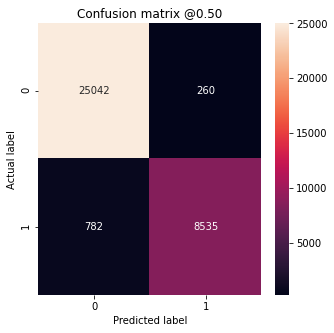

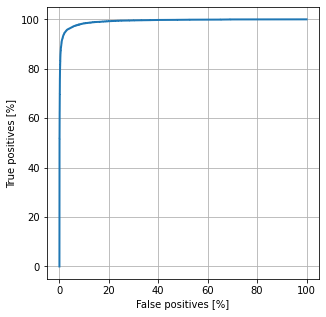

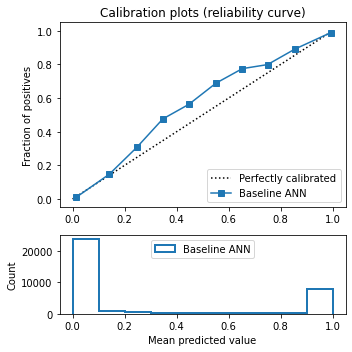

In [139]:
# Load model again
baseline_savepath = f'/content/drive/My Drive/Medicare Analysis/Data/model/NN baseline/'
model = make_model()
model.load_weights(baseline_savepath)

# Plot results
# plot_metrics(baseline_history)

baseline_results = model.evaluate(test_batches, verbose=0)
for name, value in zip(model.metrics_names, baseline_results):
  print(name, ': ', value)

train_predictions_baseline = model.predict(train_batches) > 0.5
test_predictions_baseline = model.predict(test_batches) > 0.5
test_probabilities_baseline = model.predict(test_batches)
brier_score = brier_score_loss(ytest, test_probabilities_baseline)
print("brier: %1.3f" % (brier_score))
print("ROC (AUC): %1.5f" % roc_auc_score(ytest, test_predictions_baseline))

plot_cm(ytest, test_predictions_baseline)
plt.show()

plot_roc(ytest, test_probabilities_baseline)
plt.show()

plot_calibration_curve(ytest, test_probabilities_baseline, "Baseline ANN")
plt.savefig('/content/drive/My Drive/Medicare Analysis/Week 8&9 - IEEE Paper drafting/fig_6a.pdf')

## Model with PCA

### Process

In [133]:
#split train and test sets
trainval, test = train_test_split(df, test_size=0.1, stratify = df['dead'])

#split train and validation sets
train, val = train_test_split(trainval, test_size=0.1, stratify = trainval['dead'])

ytrain = np.array(train.pop('dead'))
bool_train_labels = ytrain != 0
yval = np.array(val.pop('dead'))
ytest = np.array(test.pop('dead'))

xtrain = np.array(train)
xval = np.array(val)
xtest = np.array(test)

print("Original:")
print("xtrain[0]:", xtrain[0])
print("xvalid[0]:", xval[0])
print("xtest[0]:", xtest[0])

# Standardization
scaler = StandardScaler()
xtrain = scaler.fit_transform(xtrain)
xval = scaler.transform(xval)
xtest = scaler.transform(xtest)

print("After Standardization:")
print("xtrain[0]:", xtrain[0])
print("xvalid[0]:", xval[0])
print("xtest[0]:", xtest[0])

# PCA feature engineering
pca = PCA(random_state=2020)
xtrain = pca.fit_transform(xtrain)
xval = pca.transform(xval)
xtest = pca.transform(xtest)

print("After PCA feature engineering:")
print("xtrain[0]:", xtrain[0])
print("xvalid[0]:", xval[0])
print("xtest[0]:", xtest[0])

#construct pipelines
train_set = tf.data.Dataset.from_tensor_slices((xtrain, ytrain))
val_set = tf.data.Dataset.from_tensor_slices((xval, yval))
test_set = tf.data.Dataset.from_tensor_slices((xtest, ytest))

#batch the sets according to batch_size
batch_size = 64
train_batches = train_set.shuffle(buffer_size=1024).batch(batch_size)
val_batches = val_set.shuffle(buffer_size=1024).batch(batch_size)
test_batches = test_set.batch(batch_size)

Original:
xtrain[0]: [0.000000e+00 6.500000e+01 0.000000e+00 1.000000e+00 1.000000e+00
 9.850000e+02 1.000000e+00 2.998700e+06 2.913180e+06 2.435275e+06
 8.160000e+02 1.052000e+04 9.870000e+02 4.500000e+01 2.898556e+04
 2.753000e+03 9.870000e+02 4.351000e+03 4.700000e+01 6.400000e+01
 0.000000e+00 0.000000e+00 1.000000e+00 0.000000e+00 0.000000e+00
 0.000000e+00]
xvalid[0]: [1.000000e+00 6.700000e+01 1.000000e+00 1.000000e+00 1.000000e+00
 4.380000e+02 1.000000e+00 1.283560e+06 1.313040e+06 1.161490e+06
 3.740000e+02 1.027700e+04 4.970000e+02 2.500000e+01 1.815697e+04
 2.502500e+03 4.970000e+02 4.342000e+03 4.900000e+01 6.600000e+01
 0.000000e+00 1.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00
 0.000000e+00]
xtest[0]: [0.000000e+00 6.900000e+01 0.000000e+00 1.000000e+00 0.000000e+00
 2.304000e+03 1.000000e+00 9.339140e+06 9.119000e+06 7.848160e+06
 1.843000e+03 1.106100e+04 7.780000e+02 8.100000e+01 2.176149e+04
 2.243500e+03 7.780000e+02 4.372000e+03 4.900000e+01 6.800000e+01
 0.0

### Train

In [107]:
# Fit model with PCA
pca_model = make_model()
pca_model.load_weights(initial_weights)
pca_history = pca_model.fit(
    train_batches,
    epochs=EPOCHS,
    callbacks = [early_stopping],
    validation_data=val_batches,
    verbose=0)

# Save model
pca_savepath = f'/content/drive/My Drive/Medicare Analysis/Data/model/NN pca/'
pca_model.save_weights(pca_savepath)

### Results

loss :  0.08628705143928528
accuracy :  0.959352970123291
precision :  0.929053783416748
recall :  0.9191588759422302
auc :  0.9870366454124451
brier: 0.023
ROC (AUC): 0.95592
Legitimate Transactions Detected (True Negatives):  24956
Legitimate Transactions Incorrectly Detected (False Positives):  346
Fraudulent Transactions Missed (False Negatives):  694
Fraudulent Transactions Detected (True Positives):  8623
Total Fraudulent Transactions:  9317


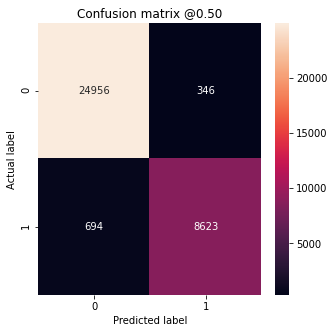

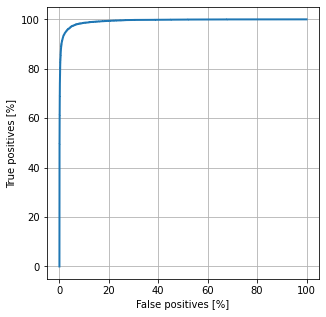

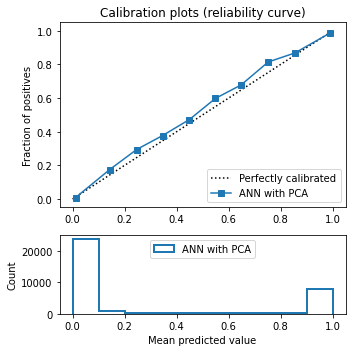

In [134]:
# Path to model
pca_savepath = f'/content/drive/My Drive/Medicare Analysis/Data/model/NN pca/'

# Load model again
pca_model = make_model()
pca_model.load_weights(pca_savepath)

# Plot results
# plot_metrics(pca_history)

pca_results = pca_model.evaluate(test_batches, verbose=0)
for name, value in zip(pca_model.metrics_names, pca_results):
  print(name, ': ', value)

train_predictions_pca = pca_model.predict(train_batches) > 0.5
test_predictions_pca = pca_model.predict(test_batches) > 0.5
test_probabilities_pca = pca_model.predict(test_batches)
brier_score = brier_score_loss(ytest, test_probabilities_pca)
print("brier: %1.3f" % (brier_score))
print("ROC (AUC): %1.5f" % roc_auc_score(ytest, test_predictions_pca))

plot_cm(ytest, test_predictions_pca)
plt.show()

plot_roc(ytest, test_probabilities_pca)
plt.show()

plot_calibration_curve(ytest, test_probabilities_pca, "ANN with PCA")
plt.savefig('/content/drive/My Drive/Medicare Analysis/Week 8&9 - IEEE Paper drafting/fig_7.pdf')

## Model with Autoencoder

### Vanila autoencoder (VA)

#### Process

In [159]:
#split train and test sets
trainval, test = train_test_split(df, test_size=0.1, stratify = df['dead'])

#split train and validation sets
train, val = train_test_split(trainval, test_size=0.1, stratify = trainval['dead'])

ytrain = np.array(train.pop('dead'))
bool_train_labels = ytrain != 0
yval = np.array(val.pop('dead'))
ytest = np.array(test.pop('dead'))

xtrain = np.array(train)
xval = np.array(val)
xtest = np.array(test)

print("Original:")
print("xtrain[0]:", xtrain[0])
print("xvalid[0]:", xval[0])
print("xtest[0]:", xtest[0])

# Standardization
scaler = StandardScaler()
xtrain = scaler.fit_transform(xtrain)
xval = scaler.transform(xval)
xtest = scaler.transform(xtest)

print("After Standardization:")
print("xtrain[0]:", xtrain[0])
print("xvalid[0]:", xval[0])
print("xtest[0]:", xtest[0])

# VA for feature engineering
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Flatten, Reshape
from keras.models import Model
from keras.optimizers import Adam

import numpy as np
import matplotlib.pyplot as plt
import keras.backend as K
import tensorflow as tf

inputs = Input(shape=(26,))
h = Dense(10, activation='relu')(inputs)
outputs = Dense(26, activation='sigmoid')(h)

model = Model(inputs, outputs)
model.compile(optimizer='adam', loss='mse')
model.fit(xtrain, xtrain, epochs=100, verbose=0)

xtrain = model.predict(xtrain)
xval = model.predict(xval)
xtest = model.predict(xtest)

print("After VA feature engineering:")
print("xtrain[0]:", xtrain[0])
print("xvalid[0]:", xval[0])
print("xtest[0]:", xtest[0])

#construct pipelines
train_set = tf.data.Dataset.from_tensor_slices((xtrain, ytrain))
val_set = tf.data.Dataset.from_tensor_slices((xval, yval))
test_set = tf.data.Dataset.from_tensor_slices((xtest, ytest))

#batch the sets according to batch_size
batch_size = 64
train_batches = train_set.shuffle(buffer_size=1024).batch(batch_size)
val_batches = val_set.shuffle(buffer_size=1024).batch(batch_size)
test_batches = test_set.batch(batch_size)

Original:
xtrain[0]: [1.000000e+00 6.800000e+01 0.000000e+00 1.000000e+00 1.000000e+00
 9.250000e+02 1.000000e+00 2.212820e+06 2.461450e+06 2.193775e+06
 7.410000e+02 1.021400e+04 4.910000e+02 4.800000e+01 1.000883e+04
 2.414300e+03 5.250000e+02 3.391000e+03 4.800000e+01 6.700000e+01
 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00 1.000000e+00
 0.000000e+00]
xvalid[0]: [1.000000e+00 4.100000e+01 0.000000e+00 1.000000e+00 0.000000e+00
 6.070000e+02 2.000000e+00 1.971100e+06 2.144760e+06 1.907050e+06
 4.890000e+02 1.093200e+04 5.000000e+02 2.900000e+01 1.350039e+04
 2.544300e+03 5.000000e+02 4.359000e+03 2.100000e+01 4.000000e+01
 1.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00
 0.000000e+00]
xtest[0]: [1.000000e+00 3.400000e+01 0.000000e+00 1.000000e+00 0.000000e+00
 6.820000e+02 1.000000e+00 5.630420e+06 3.634270e+06 3.424625e+06
 6.700000e+02 1.083400e+04 1.100000e+01 8.000000e+00 4.084800e+02
 2.522700e+02 1.100000e+01 3.796000e+03 1.500000e+01 3.400000e+01
 1.0

#### Train

In [160]:
va_model = make_model()
va_model.load_weights(initial_weights)
va_history = va_model.fit(
    train_batches,
    epochs=EPOCHS,
    callbacks = [early_stopping],
    validation_data=val_batches,
    verbose=0)

# Save model
va_savepath = f'/content/drive/My Drive/Medicare Analysis/Data/model/NN va_100/'
va_model.save_weights(va_savepath)

#### Results

loss :  0.1816122680902481
accuracy :  0.9300960898399353
precision :  0.8742716908454895
recall :  0.8645915985107422
auc :  0.9715530276298523
brier: 0.052
ROC (AUC): 0.91151
Legitimate Transactions Detected (True Negatives):  24159
Legitimate Transactions Incorrectly Detected (False Positives):  1143
Fraudulent Transactions Missed (False Negatives):  1228
Fraudulent Transactions Detected (True Positives):  8089
Total Fraudulent Transactions:  9317


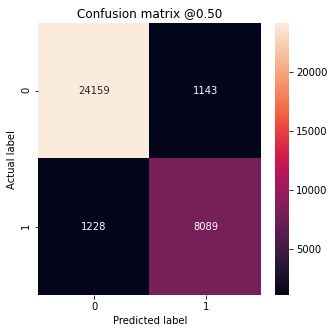

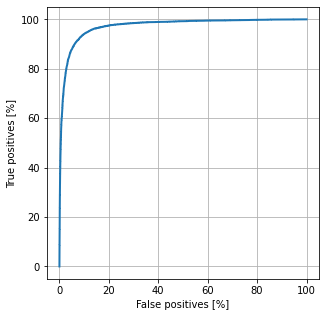

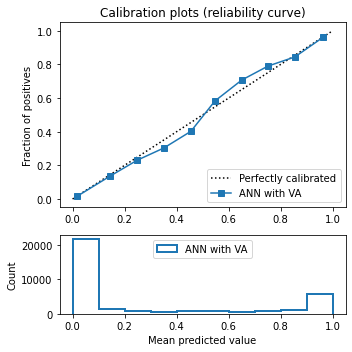

In [161]:
# Path to model
va_savepath = f'/content/drive/My Drive/Medicare Analysis/Data/model/NN va_100/'

# Load model again
va_model = make_model()
va_model.load_weights(va_savepath)

# Plot results
# plot_metrics(va_history)

va_results = va_model.evaluate(test_batches, verbose=0)
for name, value in zip(va_model.metrics_names, va_results):
  print(name, ': ', value)

train_predictions_va = va_model.predict(train_batches) > 0.5
test_predictions_va = va_model.predict(test_batches) > 0.5
test_probabilities_va = va_model.predict(test_batches)
brier_score = brier_score_loss(ytest, test_probabilities_va)
print("brier: %1.3f" % (brier_score))
print("ROC (AUC): %1.5f" % roc_auc_score(ytest, test_predictions_va))

plot_cm(ytest, test_predictions_va)
plt.show()

plot_roc(ytest, test_probabilities_va)
plt.show()

plot_calibration_curve(ytest, test_probabilities_va, "ANN with VA")
plt.savefig('/content/drive/My Drive/Medicare Analysis/Week 8&9 - IEEE Paper drafting/fig_8a.pdf')

### Sparse autoencoder (SA)

#### Process

In [156]:
#split train and test sets
trainval, test = train_test_split(df, test_size=0.1, stratify = df['dead'])

#split train and validation sets
train, val = train_test_split(trainval, test_size=0.1, stratify = trainval['dead'])

ytrain = np.array(train.pop('dead'))
bool_train_labels = ytrain != 0
yval = np.array(val.pop('dead'))
ytest = np.array(test.pop('dead'))

xtrain = np.array(train)
xval = np.array(val)
xtest = np.array(test)

print("Original:")
print("xtrain[0]:", xtrain[0])
print("xvalid[0]:", xval[0])
print("xtest[0]:", xtest[0])

# Standardization
scaler = StandardScaler()
xtrain = scaler.fit_transform(xtrain)
xval = scaler.transform(xval)
xtest = scaler.transform(xtest)

print("After Standardization:")
print("xtrain[0]:", xtrain[0])
print("xvalid[0]:", xval[0])
print("xtest[0]:", xtest[0])

# SA for feature engineering
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Flatten, Reshape
from keras.models import Model
from keras.optimizers import Adam
from keras.regularizers import l1

import numpy as np
import matplotlib.pyplot as plt
import keras.backend as K
import tensorflow as tf

inputs = Input(shape=(26,))
h = Dense(10, activation='relu', activity_regularizer=l1(10e-5))(inputs)
outputs = Dense(26, activation='sigmoid')(h)

model = Model(inputs, outputs)
model.compile(optimizer='adam', loss='mse')
model.fit(xtrain, xtrain, epochs=100, verbose=0)

xtrain = model.predict(xtrain)
xval = model.predict(xval)
xtest = model.predict(xtest)

print("After SA feature engineering:")
print("xtrain[0]:", xtrain[0])
print("xvalid[0]:", xval[0])
print("xtest[0]:", xtest[0])

#construct pipelines
train_set = tf.data.Dataset.from_tensor_slices((xtrain, ytrain))
val_set = tf.data.Dataset.from_tensor_slices((xval, yval))
test_set = tf.data.Dataset.from_tensor_slices((xtest, ytest))

#batch the sets according to batch_size
batch_size = 64
train_batches = train_set.shuffle(buffer_size=1024).batch(batch_size)
val_batches = val_set.shuffle(buffer_size=1024).batch(batch_size)
test_batches = test_set.batch(batch_size)

Original:
xtrain[0]: [0.000000e+00 6.900000e+01 1.000000e+00 1.000000e+00 1.000000e+00
 9.720000e+02 1.000000e+00 3.637250e+06 3.915420e+06 3.455845e+06
 7.560000e+02 1.104700e+04 4.240000e+02 2.600000e+01 1.160207e+04
 2.013800e+03 4.240000e+02 4.327000e+03 4.900000e+01 6.800000e+01
 1.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00
 0.000000e+00]
xvalid[0]: [0.000000e+00 4.000000e+01 0.000000e+00 1.000000e+00 0.000000e+00
 3.770000e+02 2.000000e+00 2.085560e+06 1.574560e+06 1.317245e+06
 3.310000e+02 1.079300e+04 5.200000e+01 1.600000e+01 1.105880e+03
 2.760500e+02 5.200000e+01 4.241000e+03 2.100000e+01 3.900000e+01
 0.000000e+00 1.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00
 0.000000e+00]
xtest[0]: [1.00000e+00 7.90000e+01 0.00000e+00 1.00000e+00 1.00000e+00 2.74000e+02
 1.00000e+00 1.08823e+06 1.01552e+06 8.45525e+05 2.72000e+02 7.62200e+03
 7.70000e+01 1.70000e+01 3.15851e+03 1.52400e+02 7.70000e+01 7.23000e+02
 5.90000e+01 7.80000e+01 0.00000e+00 1.00000e+00 

#### Train

In [157]:
sa_model = make_model()
sa_model.load_weights(initial_weights)
sa_history = sa_model.fit(
    train_batches,
    epochs=EPOCHS,
    callbacks = [early_stopping],
    validation_data=val_batches,
    verbose=0)

# Save model
sa_savepath = f'/content/drive/My Drive/Medicare Analysis/Data/model/NN sa_100/'
sa_model.save_weights(sa_savepath)

#### Results

loss :  0.18338757753372192
accuracy :  0.9217495918273926
precision :  0.8539211750030518
recall :  0.8556095361709595
auc :  0.9731467962265015
brier: 0.056
ROC (AUC): 0.90274
Legitimate Transactions Detected (True Negatives):  24003
Legitimate Transactions Incorrectly Detected (False Positives):  1299
Fraudulent Transactions Missed (False Negatives):  1334
Fraudulent Transactions Detected (True Positives):  7983
Total Fraudulent Transactions:  9317


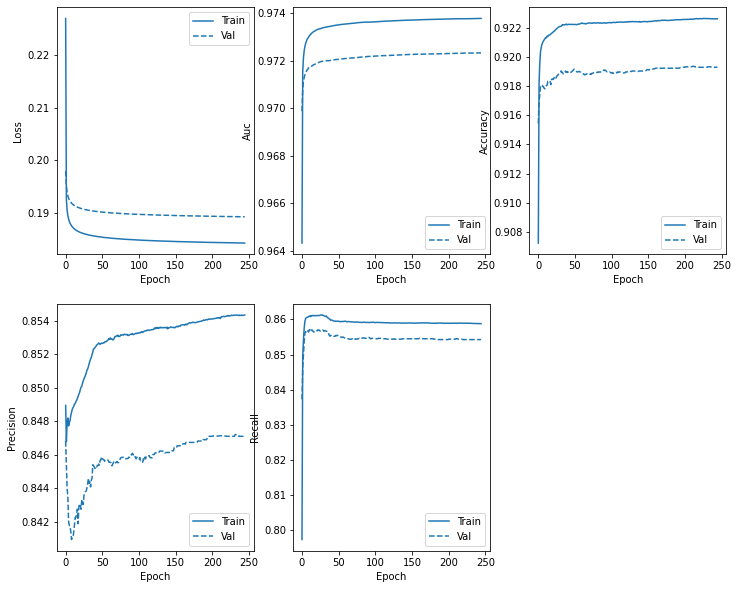

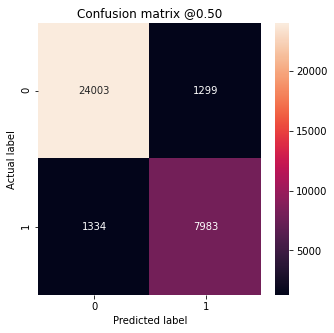

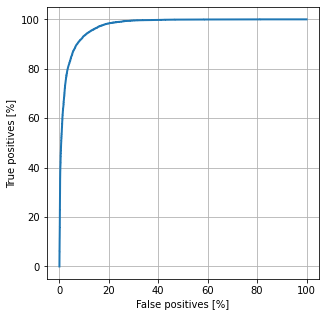

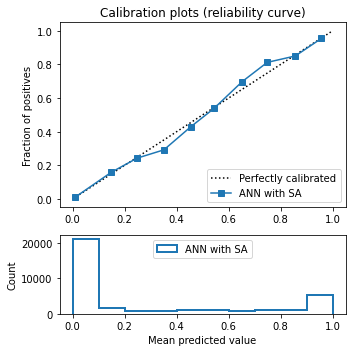

In [158]:
# Path to model
sa_savepath = f'/content/drive/My Drive/Medicare Analysis/Data/model/NN sa_100/'

# Load model again
sa_model = make_model()
sa_model.load_weights(sa_savepath)

# Plot results
plot_metrics(sa_history)

sa_results = sa_model.evaluate(test_batches, verbose=0)
for name, value in zip(sa_model.metrics_names, sa_results):
  print(name, ': ', value)

train_predictions_sa = sa_model.predict(train_batches) > 0.5
test_predictions_sa = sa_model.predict(test_batches) > 0.5
test_probabilities_sa = sa_model.predict(test_batches)
brier_score = brier_score_loss(ytest, test_probabilities_sa)
print("brier: %1.3f" % (brier_score))
print("ROC (AUC): %1.5f" % roc_auc_score(ytest, test_predictions_sa))

plot_cm(ytest, test_predictions_sa)
plt.show()

plot_roc(ytest, test_probabilities_sa)
plt.show()

plot_calibration_curve(ytest, test_probabilities_sa, "ANN with SA")
plt.savefig('/content/drive/My Drive/Medicare Analysis/Week 8&9 - IEEE Paper drafting/fig_9a.pdf')

### Multilayer autoencoder (MA)

#### Process

In [153]:
#split train and test sets
trainval, test = train_test_split(df, test_size=0.1, stratify = df['dead'])

#split train and validation sets
train, val = train_test_split(trainval, test_size=0.1, stratify = trainval['dead'])

ytrain = np.array(train.pop('dead'))
bool_train_labels = ytrain != 0
yval = np.array(val.pop('dead'))
ytest = np.array(test.pop('dead'))

xtrain = np.array(train)
xval = np.array(val)
xtest = np.array(test)

print("Original:")
print("xtrain[0]:", xtrain[0])
print("xvalid[0]:", xval[0])
print("xtest[0]:", xtest[0])

# Standardization
scaler = StandardScaler()
xtrain = scaler.fit_transform(xtrain)
xval = scaler.transform(xval)
xtest = scaler.transform(xtest)

print("After Standardization:")
print("xtrain[0]:", xtrain[0])
print("xvalid[0]:", xval[0])
print("xtest[0]:", xtest[0])

# MA for feature engineering
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Flatten, Reshape
from keras.models import Model
from keras.optimizers import Adam

import numpy as np
import matplotlib.pyplot as plt
import keras.backend as K
import tensorflow as tf

inputs = Input(shape=(26,))

# Encoder
hidden_1 = Dense(13, activation='relu')(inputs)
h = Dense(6, activation='relu')(hidden_1)

# Decoder
hidden_2 = Dense(13, activation='relu')(h)
outputs = Dense(26, activation='sigmoid')(hidden_2)

model = Model(inputs, outputs)
model.compile(optimizer='adam', loss='mse')
model.fit(xtrain, xtrain, epochs=100, verbose=0)

xtrain = model.predict(xtrain)
xval = model.predict(xval)
xtest = model.predict(xtest)

print("After VA feature engineering:")
print("xtrain[0]:", xtrain[0])
print("xvalid[0]:", xval[0])
print("xtest[0]:", xtest[0])

#construct pipelines
train_set = tf.data.Dataset.from_tensor_slices((xtrain, ytrain))
val_set = tf.data.Dataset.from_tensor_slices((xval, yval))
test_set = tf.data.Dataset.from_tensor_slices((xtest, ytest))

#batch the sets according to batch_size
batch_size = 64
train_batches = train_set.shuffle(buffer_size=1024).batch(batch_size)
val_batches = val_set.shuffle(buffer_size=1024).batch(batch_size)
test_batches = test_set.batch(batch_size)

Original:
xtrain[0]: [1.000000e+00 9.100000e+01 0.000000e+00 1.000000e+00 0.000000e+00
 4.370000e+02 1.000000e+00 2.631580e+06 2.409120e+06 2.039135e+06
 4.340000e+02 7.734000e+03 1.250000e+02 9.000000e+00 5.998500e+03
 2.060400e+03 1.250000e+02 8.210000e+02 7.100000e+01 9.000000e+01
 1.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00
 0.000000e+00]
xvalid[0]: [1.00000e+00 8.00000e+01 0.00000e+00 1.00000e+00 0.00000e+00 7.16000e+02
 1.00000e+00 2.50884e+06 2.68056e+06 2.36038e+06 6.13000e+02 1.12450e+04
 1.96000e+02 1.30000e+01 4.76646e+03 1.00370e+03 1.96000e+02 4.32300e+03
 6.00000e+01 7.90000e+01 0.00000e+00 0.00000e+00 1.00000e+00 0.00000e+00
 0.00000e+00 0.00000e+00]
xtest[0]: [1.000000e+00 8.300000e+01 0.000000e+00 1.000000e+00 0.000000e+00
 8.290000e+02 1.000000e+00 2.297700e+06 2.553680e+06 2.263705e+06
 6.610000e+02 1.121500e+04 9.870000e+02 4.500000e+01 2.231053e+04
 3.927100e+03 9.870000e+02 4.370000e+03 6.300000e+01 8.200000e+01
 1.000000e+00 0.000000e+00 0.00

#### Train

In [154]:
ma_model = make_model()
ma_model.load_weights(initial_weights)
ma_history = ma_model.fit(
    train_batches,
    epochs=EPOCHS,
    callbacks = [early_stopping],
    validation_data=val_batches,
    verbose=0)

# Save model
ma_savepath = f'/content/drive/My Drive/Medicare Analysis/Data/model/NN ma_100/'
ma_model.save_weights(ma_savepath)

#### Results

loss :  0.17001701891422272
accuracy :  0.9278308153152466
precision :  0.8531320095062256
recall :  0.8840243816375732
auc :  0.9771336317062378
brier: 0.052
ROC (AUC): 0.91402
Legitimate Transactions Detected (True Negatives):  23930
Legitimate Transactions Incorrectly Detected (False Positives):  1372
Fraudulent Transactions Missed (False Negatives):  1097
Fraudulent Transactions Detected (True Positives):  8220
Total Fraudulent Transactions:  9317


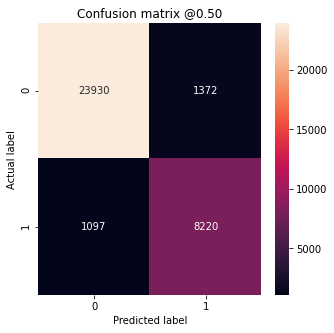

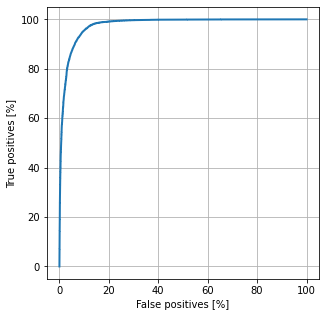

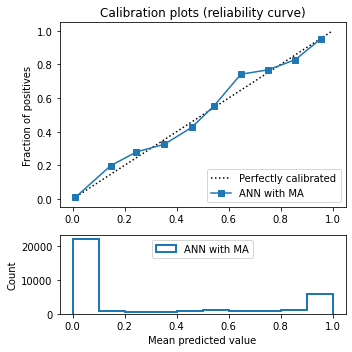

In [155]:
# Path to model
ma_savepath = f'/content/drive/My Drive/Medicare Analysis/Data/model/NN ma_100/'

# Load model again
ma_model = make_model()
ma_model.load_weights(ma_savepath)

# Plot results
# plot_metrics(ma_history)

ma_results = ma_model.evaluate(test_batches, verbose=0)
for name, value in zip(ma_model.metrics_names, ma_results):
  print(name, ': ', value)

train_predictions_ma = ma_model.predict(train_batches) > 0.5
test_predictions_ma = ma_model.predict(test_batches) > 0.5
test_probabilities_ma = ma_model.predict(test_batches)
brier_score = brier_score_loss(ytest, test_probabilities_ma)
print("brier: %1.3f" % (brier_score))
print("ROC (AUC): %1.5f" % roc_auc_score(ytest, test_predictions_ma))

plot_cm(ytest, test_predictions_ma)
plt.show()

plot_roc(ytest, test_probabilities_ma)
plt.show()

plot_calibration_curve(ytest, test_probabilities_ma, "ANN with MA")
plt.savefig('/content/drive/My Drive/Medicare Analysis/Week 8&9 - IEEE Paper drafting/fig_10a.pdf')